# Jupyter with PostgreSQL

## Libararies and Settings

In [5]:
# Libraries
import os
import re
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

/


## Create database connection

In [6]:
conn = psycopg2.connect("host=localhost dbname=app user=app_user password=app_password")

## Read data

In [7]:
df = pd.read_csv('/workspace/Tutti.csv', sep=',')
df.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-
2,1703597180-3,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 26.06.2018, auf autoscout24.ch",LANCIA Dedra 2.0 HF Integrale,6'950.-
3,1703597180-4,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 3604, 04.06.2018, auf autoscout24.ch",LANCIA BETA 2000 Spider,19'990.-
4,1703597180-5,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 4943, 04.04.2018, auf autoscout24.ch",VW Polo 1300 C (X),12'900.-


## Count number of rows and columns in the data frame

In [8]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (2804, 5)
Number of rows: 2804
Number of columns: 5


## Extract and save relevant information from raw data using regular expressions (regex)

### Extract Canton

In [9]:
# Extrahiere das erste Wort vor dem Komma in den Strings der 'location_date' Spalte
cantons = []
for i in df['location_date']:
    split_string = i.split(',')[0].strip()  # Teilt den String am Komma und nimmt den ersten Teil
    cantons.append(split_string)

# Speichere als neue Variable im Pandas DataFrame
df['canton'] = cantons

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['canton'].head(5))

0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0      Waadt
1     Aargau
2    Thurgau
3       Bern
4       Bern
Name: canton, dtype: object


### Extract PLZ

In [10]:

# Extrahiere die PLZ, die nach dem ersten und vor dem zweiten Komma kommt
plz_list = []
for i in df['location_date']:
    parts = i.split(',')
    try:
        plz = parts[1].strip()  # Wählt den zweiten Teil nach dem Split, der die PLZ enthält
    except IndexError:
        plz = None  # Falls weniger als 2 Kommas vorhanden sind
    plz_list.append(plz)

# Speichere als neue Variable im Pandas DataFrame
df['plz'] = plz_list

df = df[df['plz'].apply(lambda x: len(str(x)) == 4)]

try:
    df['plz'] = df['plz'].astype('int64')
except ValueError:
    print("Konvertierung fehlgeschlagen: Die Spalte enthält ungültige oder fehlende Werte.")

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['plz'].head(5))


0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0    1026
1    5054
2    8370
3    3604
4    4943
Name: plz, dtype: int64


In [11]:
df.dtypes

web-scraper-order        object
web-scraper-start-url    object
location_date            object
brand_type               object
price                    object
canton                   object
plz                       int64
dtype: object

## Count and identify missing values (if any)

In [12]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order        0
web-scraper-start-url    0
location_date            0
brand_type               0
price                    0
canton                   0
plz                      0
dtype: int64


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


### Count and identify dublicates

In [13]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'location_date', 'brand_type']].duplicated()]

0


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


In [14]:
# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('/workspace/PLZ_Ortschaft_BFSNummer.csv', 
                     sep=';', 
                     encoding='utf-8')

# Rename columns
df_geo = df_geo.rename(columns={'Gemeindename':'ort',
                                'BFS-Nr':'bfs_number', 
                                'PLZ':'plz'})

# Show data
df_geo[['ort', 
        'bfs_number', 
        'plz']].head()

,ort,bfs_number,plz
0,Aeugst am Albis,1,8914
1,Aeugst am Albis,1,8914
2,Affoltern am Albis,2,8909
3,Affoltern am Albis,2,8910
4,Bonstetten,3,8906


### Join informations

In [15]:
df2 = df.merge(df_geo[['ort',  
                       'bfs_number', 
                       'plz']], 
               on="plz")
df2.head()


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Denges,5632
1,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Echandens,5633
2,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-,Aargau,5054,Kirchleerau,4275
3,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-,Aargau,5054,Moosleerau,4277
4,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5'990.-,Aargau,5054,Kirchleerau,4275


## Add municipalities

In [16]:
df_municip = pd.read_excel('/workspace/municipality_data.xlsx', 
                           sheet_name='data_for_import')
df_municip.head(5)

,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0
2,3,Bonstetten,5572,749.932705,16.564968,1014.0
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0
4,5,Hedingen,3778,578.560490,16.410799,1478.0


In [18]:
# Merge needs a key which must be identical in both data sets (here the key is 'bfs_number')
df3 = df2.merge(df_municip[['bfs_number', 
                            'pop', 
                            'pop_dens', 
                            'frg_pct', 
                            'emp']], 
                on="bfs_number")
df3.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0
1,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0
2,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0
3,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0
4,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0


## Write data to database

In [23]:
engine = create_engine('postgresql://app_user:app_password@db:5432/app')
df3.to_sql('car_table', engine, if_exists='replace')

820

## Make SQL query

In [24]:
df_sub = pd.read_sql_query('''SELECT
                             brand_type,
                             price,
                           canton,
                           plz,
                           ort,
                           bfs_number,
                           pop,
                           pop_dens,
                           frg_pct,
                           emp
                             FROM car_table''', 
                          con=engine)
df_sub.head()

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp
0,LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0
1,LANCIA Dedra 2.0 i.e. LX,3'900.-,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0
2,VW Golf 1800 S-Plus (GL),5'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0
3,MITSUBISHI Colt 1400 GLX A,5'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0
4,ROVER 827 Vitesse A,6'990.-,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0


## Plot apartment prices

AttributeError: This method only works with the ScalarFormatter

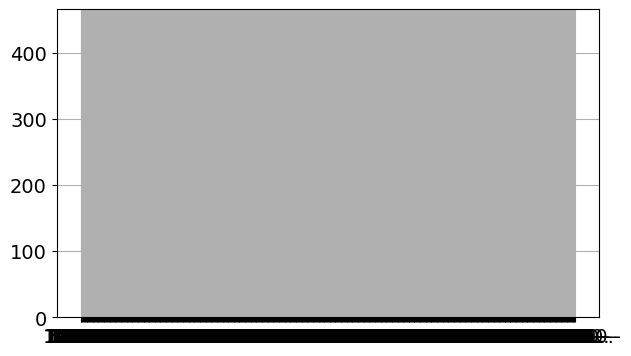

In [ ]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df['price'], 
                            bins=20, 
                            color='#5DADE2',
                            alpha=1.00, 
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('price', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.title('Histogram of apartment prices', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1018-azure
Datetime: 2023-12-30 12:40:34
Python Version: 3.10.12
-----------------------------------
